# Euro Cup Predictions
Look at scores distribution of a typical Euro CUP and mimic scores

Use FIFA rankings to distribute scores by goal differential

A blog post about these predictions can be found at [Towards Data Science](https://sijmenvdw.medium.com/predict-euro-cup-matches-with-simple-statistics-2fc913678117).

By: Sijmen van der Willik

### Import libraries

In [1]:
import json
import pandas as pd
import numpy as np

### Load data

In [2]:
fifa = json.load(open("fifa.json"))
games = json.load(open("games_group_stage.json"))
df = pd.read_csv("euro_cup_games.csv")

### Wrangle data

In [3]:
# only use non-qualifying games
df = df[df['round'] != 'QUALIFYING'].copy()

In [4]:
# add max-min column
#  - stores the max - min goals from a match so outcomes can be easily compared
#  - i.e. 2-1 and 1-2 both output 2-1
def get_maxmin(x):
    scores = [int(x) for x in x.split("-")]
    return f"{max(scores)}-{min(scores)}"

df['maxmin'] = df['score'].apply(get_maxmin)

In [5]:
# add scores as int so difference can be calculated
df[['score1', 'score2']] = df['score'].str.split("-", n=1, expand=True)
df['score1'] = df['score1'].astype(int)
df['score2'] = df['score2'].astype(int)

In [6]:
# count the number of occurrence for each match outcome and save into a DataFrame
df2 = df[['edition', 'maxmin']].groupby("edition")['maxmin'].value_counts().copy()

# init DataFrame for totals
totals = pd.DataFrame(index=sorted(df['maxmin'].unique()))

# fill the DataFrame
for idx, v in zip(df2.index, df2.values):
    edition, maxmin = idx
    
    if edition not in totals:
        totals[edition] = np.nan
    
    totals.loc[maxmin, edition] = v
totals = totals.fillna(0)
totals = totals.astype(int)

In [7]:
# calculate estimates
fractions = totals/totals.sum()
ests = fractions.mean(axis=1) * len(games)

In [8]:
# save estimates to DataFrame
edf = pd.DataFrame(ests)
edf.columns = ['E']

# add maxmin and score differentials as columns for easy comparison later
edf['maxmin'] = edf.index
edf['diff'] = edf['maxmin'].apply(lambda x: int(x[0]) - int(x[2]))

In [9]:
def build_n(e):
    n = [int(x) for x in e]
    e = [x % 1 for x in e]
    
    while sum(n) < len(games):
        idx = np.argmax(e)
        e[idx] = 0
        n[idx] += 1
    
    return n

edf['n'] = build_n(edf['E'])

In [10]:
# create game DataFrame
gdf = pd.DataFrame(games)
gdf.columns = ['c1', 'c2']

# add columns for FIFA ranks and differences
gdf['r1'] = gdf['c1'].apply(lambda x: fifa[x])
gdf['r2'] = gdf['c2'].apply(lambda x: fifa[x])
gdf['r_diff'] = gdf['r1'] - gdf['r2']
gdf['r_diff_abs'] = np.abs(gdf['r_diff'])

In [11]:
# create a sorted list of the scores to distribute
score_list = []

for _, row in edf.sort_values(by='diff').iterrows():
    for i in range(row['n']):
        score_list.append(row['maxmin'])

In [12]:
# sort the games by FIFA rank difference
gdf = gdf.sort_values(by=['r_diff_abs'])

In [13]:
# add the scores the games DataFrame
gdf['pred'] = score_list
gdf['pred'] = gdf.apply(lambda row: row['pred'][::-1] if row['r_diff'] > 0 else row['pred'], axis=1)

## Result

In [14]:
# show the games with predictions in their original order
gdf.sort_index()

,c1,c2,r1,r2,r_diff,r_diff_abs,pred
0,turkey,italy,29,7,22,22,1-2
1,wales,switzerland,17,13,4,4,0-0
2,denmark,finland,10,54,-44,44,3-0
3,belgium,russia,1,38,-37,37,3-1
4,england,croatia,4,14,-10,10,1-0
5,austria,north macedonia,23,62,-39,39,4-2
6,netherlands,ukraine,16,24,-8,8,1-1
7,scotland,czech,44,40,4,4,1-1
8,poland,slovakia,21,36,-15,15,1-0
9,spain,sweden,6,18,-12,12,1-0


## Plots

Additional plots are created for the [blog post](https://sijmenvdw.medium.com/predict-euro-cup-matches-with-simple-statistics-2fc913678117).

In [15]:
import matplotlib.pyplot as plt

### Occurrence table

In [16]:
t = totals
t.columns = [x.split("-")[0] for x in t.columns]
t.astype(str).replace("0", "")

,1960,1964,1968,1972,1976,1980,1984,1988,1992,1996,2000,2004,2008,2012,2016
0-0,,2,1,3,,3,1,,3,5,4,5,2,4,4
1-0,2,7,2,1,,3,3,4,2,6,6,9,6,8,14
1-1,2,10,2,1,2,3,3,2,2,5,3,4,3,6,10
2-0,6,5,4,,3,,2,5,2,4,6,2,7,5,11
2-1,2,6,1,4,1,3,1,1,2,5,9,8,4,6,10
2-2,1,1,,1,2,,,,1,,,4,,,2
3-0,5,2,1,2,,,,,1,4,4,4,2,1,4
3-1,1,10,,1,1,1,,2,1,1,,1,2,1,1
3-2,1,3,1,,1,1,3,1,1,,3,1,3,2,
3-3,,2,,,,,,,,1,1,,,,1


### Heatmap

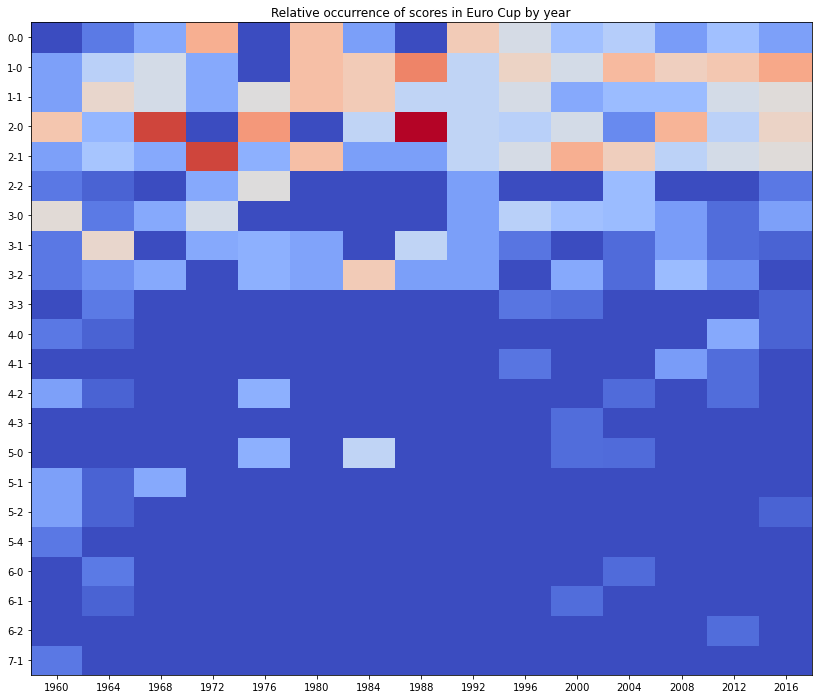

In [17]:
df = fractions

plt.figure(figsize=(14,12))
plt.pcolor(df[::-1], cmap='coolwarm')
yticks = np.arange(0.5, len(df.index), 1)
plt.yticks(list(reversed(yticks)), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), [x.split("-")[0] for x in df.columns])
plt.title("Relative occurrence of scores in Euro Cup by year")
plt.show()